# Study of the physical dataset

In this notebook, we will study how different models perform on the physical dataset. Some of the models we will study are:
1. Non-supervised:
    - Isolation Forest (IF)
    - Local Outlier Factor (LOF)
2. Neural physicals:
    - DNN
    - LSTM
3. Supervised classifiers:
    - Decision Tree
    - Random Forest
    - XGBoost

First, let's import the necessary libraries.

In [78]:
from preprocess_data import get_HITL, clean_HITL, prepare_HTIL_physical_dataset, remove_physical_contextual_columns

from mlsecu.data_exploration_utils import (
    get_column_names,
    get_nb_of_dimensions,
    get_nb_of_rows,
    get_object_column_names,
    get_number_column_names,
)
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.activations import swish, sigmoid, softmax

BASE_PATH = "../../data/"
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

import warnings
warnings.simplefilter(action='ignore')

# Load and prepare the dataset

We have defined multiple preprocessing functions in the `preprocessing.py` file. We will use them to load and prepare the dataset.

In [79]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=False)
_, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Physical dataset shape: ", df_physical.shape)

Physical dataset shape:  (9206, 44)


This dataset has way fewer rows than the network one, this might cause some problems later.

- The `get_HITL` loads all the csv files into a dictionnary that can be used later to load the data. Regarding the network dataset, we only keep 1% of the normal data to make the dataset more usable. The physical dataset is very small by default (9000 rows) so we keep the full version.
- The `clean_HITL` function takes all 3 attack files and the normal file and concatenates them into a single dataframe, for both dataframes. Then it performs these operations (among others, see the function for more details):
    - It also adds a column `label` to the dataframe which is 1 for attack and 0 for normal.
    - Fixes the misspelled column `lable_n` and merges it with the `label_n` column.
    - Convert the `timestamp` column to a datetime object.

In [80]:
df_physical_prepared, df_physical_labels = prepare_HTIL_physical_dataset(df_physical)
df_physical_prepared.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,pump_6,flow_sensor_1,flow_sensor_2,flow_sensor_4,valv_12,valv_15,valv_17,valv_18,valv_20,valv_22
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We prepare the dataset by calling `prepare_HTIL_physical_dataset`. This function does the following:
- Remove NaN through mean imputation of numerical features.
- Convert label categories to numerical values.

The features are :
- `time`: the timestamp of the measurement
- `tank_X`: the level of the tank X
- `pump_Y`: the level of the pump Y
- `valv_Z`: the level of the valve Z
- `flow_sensor_W`: the amount of water flowing through the sensor W

In [81]:
df_physical_labels.head()

,label_n,label,attack,new_labels
0,0.0,normal,1,2
1,0.0,normal,1,2
2,0.0,normal,1,2
3,0.0,normal,1,2
4,0.0,normal,1,2


# Models analysis

## 1. Non-supervised models

### a. Isolation Forest

As a first step, let's try default parameters for the Isolation Forest model.

In [5]:
df_physical_labels["label_n"].value_counts()

label_n
0.0    7747
1.0    1459
Name: count, dtype: int64

In [12]:
clf = IsolationForest(random_state=42)
y_pred = clf.fit_predict(df_physical_prepared)
if_outliers = df_physical_prepared[y_pred == -1].index.values.tolist()
len(if_outliers)

5762

In [8]:
df_physical_labels.iloc[if_outliers]["label_n"].value_counts()

label_n
0.0    4607
1.0    1155
Name: count, dtype: int64

Out of the 5762 outliers found, 1155 are real anomalies (20%). This is not a great result knowing there are only 1459 outliers, let's see if we can do better with a fixed contamination rate.

In [9]:
val_counts_labels = df_physical_labels["label_n"].value_counts()
contamination_rate = val_counts_labels[1] / (val_counts_labels[0] + val_counts_labels[1])
contamination_rate

0.1584835976537041

In [17]:
clf = IsolationForest(n_estimators=100, n_jobs=-1, bootstrap=True, random_state=42, contamination=contamination_rate)
y_pred = clf.fit_predict(df_physical_prepared)
if_outliers_cr = df_physical_prepared[y_pred == -1].index.values.tolist()
len(if_outliers_cr)

1458

In [15]:
df_physical_labels.iloc[if_outliers_cr]["label_n"].value_counts()

label_n
0.0    936
1.0    522
Name: count, dtype: int64

With a fixed contamination rate, the model gets a total of 1459 outliers, out of which 522 are real anomalies (35.7%). This is a better result than with the default parameters and less false positives are found, however it's still not close to being usable in a real-world scenario.

### b. Local Outlier Factor

In [18]:
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit_predict(df_physical_prepared)
lof_outliers = df_physical_prepared[y_pred == -1].index.values.tolist()
len(lof_outliers)

73

In [19]:
df_physical_labels.iloc[lof_outliers]["label_n"].value_counts()

label_n
0.0    48
1.0    25
Name: count, dtype: int64

We get terrible results, it barely detects outliers. This model isn't suited for the dataset.

What we saw with these two methods, is that they are not suited for this dataset. The dataset is surely too small for these methods to work properly and capture the outliers. Let's see if more complex models can do better.

## 2. Neural Networks

### a. DNN

We will use only some of the columns for the DNN model. We are removing contextual information such as the time. To make it easier to manipulate, we will merge back the labels with the predictions.

#### Binary classification

In [82]:
df = df_physical_prepared.copy()
df["label_n"] = df_physical_labels["label_n"]
df.head()

,time,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,...,flow_sensor_1,flow_sensor_2,flow_sensor_4,valv_12,valv_15,valv_17,valv_18,valv_20,valv_22,label_n
0,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,1.630780e+09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,1.630780e+09,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


In [83]:
# convert bool columns to int
bool_cols = df.columns[df.dtypes == bool]
df[bool_cols] = df[bool_cols].astype(int)

# remove time column
if "Time" in df.columns:
    df.drop(columns=['Time'], inplace=True)

# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_n'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label_n'])

# Separate features and target
X_train = train_df.drop(columns=['label_n'])
y_train = train_df['label_n']
X_val = val_df.drop(columns=['label_n'])
y_val = val_df['label_n']
X_test = test_df.drop(columns=['label_n'])
y_test = test_df['label_n']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((5891, 23), (1473, 23), (1842, 23))

In [84]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(1, activation=sigmoid)  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1024)              24576     
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 303489 (1.16 MB)
Trainable params: 303489 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are using a simple DNN with 3 hidden layers, but it should be enough to get good results. We are using the `binary_crossentropy` loss function, since we are focusing on binary classification, and the `adam` optimizer. We are using the `accuracy` metric to evaluate the model.

Let's define callbacks and train the model.

In [85]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=6, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/40
24/24 [==============================] - 0s 9ms/step - loss: 0.4680 - accuracy: 0.8009 - val_loss: 0.3676 - val_accuracy: 0.8554 - lr: 0.0010
Epoch 2/40
24/24 [==============================] - 0s 6ms/step - loss: 0.3697 - accuracy: 0.8416 - val_loss: 0.3293 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 3/40
24/24 [==============================] - 0s 6ms/step - loss: 0.3114 - accuracy: 0.8678 - val_loss: 0.2814 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 4/40
24/24 [==============================] - 0s 6ms/step - loss: 0.3106 - accuracy: 0.8572 - val_loss: 0.2928 - val_accuracy: 0.8751 - lr: 0.0010
Epoch 5/40
24/24 [==============================] - 0s 8ms/step - loss: 0.2972 - accuracy: 0.8791 - val_loss: 0.2637 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 6/40
24/24 [==============================] - 0s 6ms/step - loss: 0.2572 - accuracy: 0.8854 - val_loss: 0.2337 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 7/40
24/24 [==============================] - 0s 6ms/step - loss: 0.2393 - a

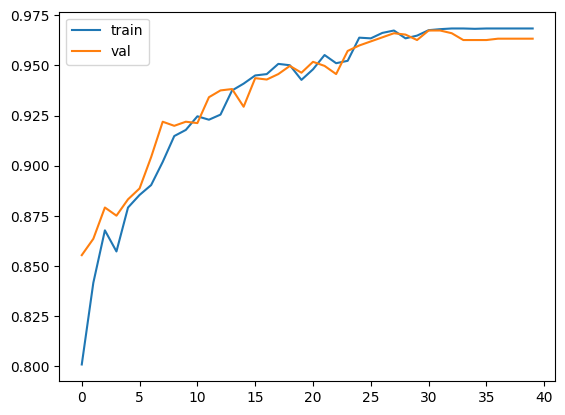

In [86]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

The curves look very good and we see that the model is training very well. Let's evaluate the model on the test set.

Evaluation on the test set:

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

 1/58 [..............................] - ETA: 0s - loss: 0.1101 - accuracy: 0.9375

58/58 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.9723
Test accuracy: 97.23%


In [27]:
def plot_confusion_matrix(y_true, y_pred, title=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    cm = confusion_matrix(y_true, y_pred)

    # normalize it
    cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    if title:
        ax.set_title(title)
    plt.show()

58/58 [==============================] - 0s 859us/step


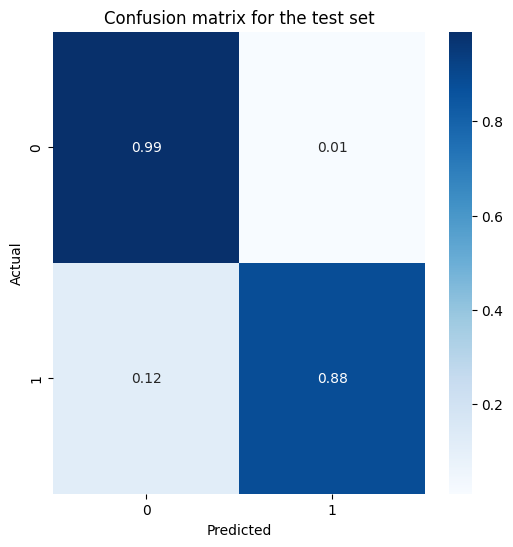

In [28]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

The results are promising, we get a good recall and precision, and 97% of test accuracy which is brilliant. The model is able to detect 88% of the anomalies and has a low false positive rate. However we still have quite a lot of false negatives, and we hope we can fix that with the next model.

This notebook doesn't show it, but we tested several different architectures and parameters for the model, on it didn't improve the results significantly to justify the extra complexity.

#### Multiclass classification

Now, we want to create an alternative DNN which will give us more precision on the type of attack. We will use the same architecture as before, but we will change the output layer to have 5 neurons, one for each type of attack.

In [29]:
df.drop(columns=['label_n'], inplace=True)
df["new_labels"] = df_physical_labels["new_labels"]
df["new_labels"].value_counts()

new_labels
2    7747
1     743
3     552
0     157
4       7
Name: count, dtype: int64

The 5th class has only 7 rows, which is not enough to train a model. We will remove it from the dataset.

In [30]:
df = df[df["new_labels"] != 4]

In [31]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['new_labels'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['new_labels'])

# Separate features and target
X_train = train_df.drop(columns=['new_labels'])
y_train = train_df['new_labels']
X_val = val_df.drop(columns=['new_labels'])
y_val = val_df['new_labels']
X_test = test_df.drop(columns=['new_labels'])
y_test = test_df['new_labels']

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((5887, 23), (1472, 23), (1840, 23))

In [32]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train[0].shape[0],)),  # Input layer
    tf.keras.layers.Dense(1024, activation=swish),  # Hidden layer 1
    tf.keras.layers.Dense(256, activation=swish),   # Hidden layer 2
    tf.keras.layers.Dense(64, activation=swish),   # Hidden layer 3
    tf.keras.layers.Dense(5, activation=softmax)  # Output layer
])

# Compile the model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              24576     
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 303749 (1.16 MB)
Trainable params: 303749 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_on_plateau])

Epoch 1/40


23/23 [==============================] - 1s 9ms/step - loss: 0.8469 - accuracy: 0.7872 - val_loss: 0.4732 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - 0s 7ms/step - loss: 0.3981 - accuracy: 0.8692 - val_loss: 0.3619 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - 0s 6ms/step - loss: 0.3025 - accuracy: 0.8842 - val_loss: 0.2886 - val_accuracy: 0.8845 - lr: 0.0010
Epoch 4/40
23/23 [==============================] - 0s 7ms/step - loss: 0.2363 - accuracy: 0.9091 - val_loss: 0.2355 - val_accuracy: 0.9056 - lr: 0.0010
Epoch 5/40
23/23 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.9259 - val_loss: 0.2006 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 6/40
23/23 [==============================] - 0s 7ms/step - loss: 0.1667 - accuracy: 0.9353 - val_loss: 0.1733 - val_accuracy: 0.9253 - lr: 0.0010
Epoch 7/40
23/23 [==============================] - 0s 7ms/step - loss: 0.1428 - accuracy: 0.

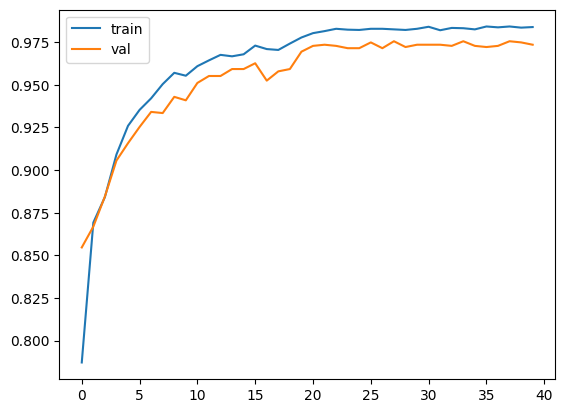

In [34]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

The curves are very similar than with the binary classification, which is a good sign. Let's evaluate the model on the test set.

Evaluate on the test set:

In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

 1/58 [..............................] - ETA: 0s - loss: 0.1262 - accuracy: 0.9375

58/58 [==============================] - 0s 976us/step - loss: 0.0636 - accuracy: 0.9783
Test accuracy: 97.83%


58/58 [==============================] - 0s 752us/step


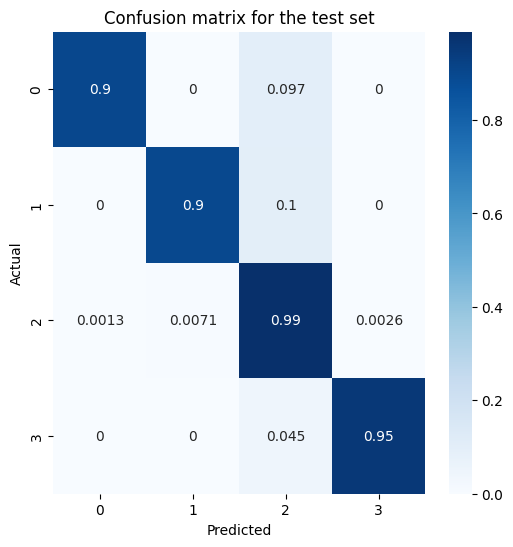

In [36]:
y_pred = model.predict(X_test)
y_pred = y_pred = np.argmax(y_pred, axis=1)

plot_confusion_matrix(y_test, y_pred, title="Confusion matrix for the test set")

In [37]:
print("Recall: ", recall_score(y_test, y_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_pred, average='macro'))
print("F1-score: ", f1_score(y_test, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Recall:  0.9365330945304965
Precision:  0.9514981314147057
F1-score:  0.9439058055650589
Accuracy:  0.9782608695652174


The model has better results overall with 98% accuracy. The number of false negatives has been significantly reduced, but we still have a lot of false positives. We could say this is an improvement from before, as it's generally better for security to have false positives than false negatives.

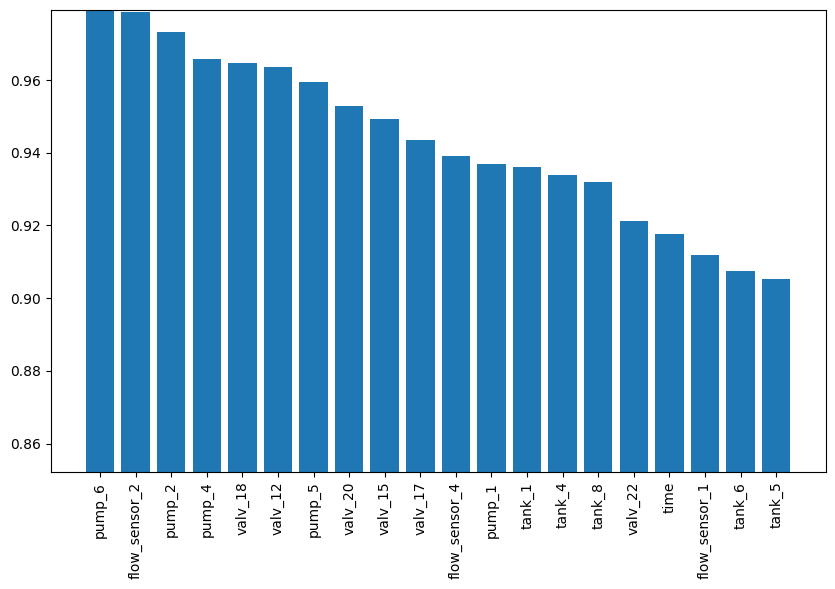

In [39]:
def get_feature_importance(model, X_train, y_train):
    feature_importance = np.zeros(X_train.shape[1])
    for i in range(X_train.shape[1]):
        X_train_perm = X_train.copy()
        np.random.shuffle(X_train_perm[:, i])
        feature_importance[i] = model.evaluate(X_train_perm, y_train, verbose=0)[1]
    return feature_importance

feature_importance = get_feature_importance(model, X_train, y_train)

topk = 20
top_features = np.argsort(feature_importance)[::-1][:topk]
plt.figure(figsize=(10, 6))
plt.bar(range(topk), feature_importance[top_features])
plt.xticks(range(topk), df.columns[top_features], rotation=90)
plt.ylim(feature_importance.min(), feature_importance.max())
plt.show()

Many features seems to be as important as the others. This tells us that the model is not overfitting and that the features are all relevant.

Looking at these results, we can say that such a model could be used in production without compromising too much the overall system. Obviously, the model struggles more with MITM and DoS attacks because they are less linked to physical parameters, but it still performs well.

#### Adversarial attacks

Let's try to look at the robustness of our model against adversarial attacks

As our model is a DNN (deep neural network) trained with gradient descent, we will use an evasion attack called FastGradientMethod to generate the adversarial samples from both the training and the test set. It works as follow: 

The Fast Gradient Sign Method (FGSM) is a technique for crafting adversarial examples to fool machine learning models:

* Start with a legitimate input.
* Compute the gradient of the loss.
* Take the sign of the gradient.
* Multiply by a small constant ε for perturbation.
* Add this perturbation to the input.
* The modified input often fools the model into making incorrect predictions.
FGSM is efficient and widely used but has led to research in defense mechanisms against such attacks.

In [69]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from copy import deepcopy

model_copy = deepcopy(model)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

classifier = TensorFlowV2Classifier(model=model_copy, nb_classes=5, input_shape=(X_train.shape[0],), loss_object=loss, optimizer=optimizer, clip_values=(X_train.min(), X_train.max()))

Let's verify we still have the same accuracy

In [70]:
predictions = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 97.77173913043478%


Generate adversarial test examples by using Fast Gradient Method

In [71]:
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=X_test)

In [72]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 48.69565217391305%


In [73]:
model_copy.evaluate(x_test_adv, y_test)

58/58 [==============================] - 0s 2ms/step - loss: 2.6133 - accuracy: 0.4870


[2.6133041381835938, 0.48695650696754456]

We can see that the accuracy dropped from 97% to 49% on the attack exemples.
Let's see if we fine tune our base model with the adversarial attacks if we can make it robuster

In [74]:
x_train_adv = attack.generate(x=X_train)
x_train_adv.shape

(5887, 41)

Let's generate different adversarial examples with different epsilons, this will be useful in the next steps

In [75]:
epsilons = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 1]
attack_points = {}
for e in epsilons:
    attack = FastGradientMethod(estimator=classifier, eps=e)
    x_adv = attack.generate(x=X_test)
    attack_points[e] = x_adv

In [76]:
history_fine_tune = model_copy.fit(x_train_adv, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10


23/23 [==============================] - 1s 12ms/step - loss: 1.6219 - accuracy: 0.7201 - val_loss: 0.2673 - val_accuracy: 0.9246
Epoch 2/10
23/23 [==============================] - 0s 8ms/step - loss: 0.6856 - accuracy: 0.8109 - val_loss: 0.1949 - val_accuracy: 0.9205
Epoch 3/10
23/23 [==============================] - 0s 8ms/step - loss: 0.4278 - accuracy: 0.8607 - val_loss: 0.1940 - val_accuracy: 0.9178
Epoch 4/10
23/23 [==============================] - 0s 8ms/step - loss: 0.3192 - accuracy: 0.8879 - val_loss: 0.1741 - val_accuracy: 0.9164
Epoch 5/10
23/23 [==============================] - 0s 8ms/step - loss: 0.2567 - accuracy: 0.9052 - val_loss: 0.1709 - val_accuracy: 0.9198
Epoch 6/10
23/23 [==============================] - 0s 8ms/step - loss: 0.2154 - accuracy: 0.9205 - val_loss: 0.1678 - val_accuracy: 0.9212
Epoch 7/10
23/23 [==============================] - 0s 8ms/step - loss: 0.1850 - accuracy: 0.9319 - val_loss: 0.1655 - val_accuracy: 0.9205
Epoch 8/10
23/23 [============

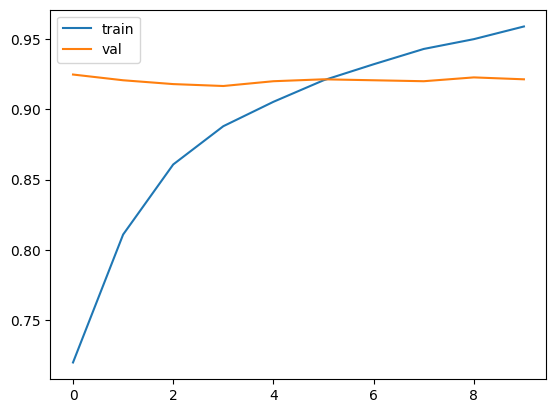

In [77]:
plt.plot(history_fine_tune.history['accuracy'], label='train')
plt.plot(history_fine_tune.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [78]:
model_copy.evaluate(X_test, y_test)

58/58 [==============================] - 0s 4ms/step - loss: 0.1506 - accuracy: 0.9315


[0.1505502313375473, 0.9315217137336731]

In [79]:
model_copy.evaluate(x_test_adv, y_test)

 1/58 [..............................] - ETA: 1s - loss: 0.1315 - accuracy: 0.9062

58/58 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9500


[0.15580178797245026, 0.949999988079071]

We 've lost 2% on the accuracy on normal exemple but we improved from 0.47 to 0.94 on adversarial sample which means that our model is way more robust now.

Let's see the robustness as a function of the perturbation

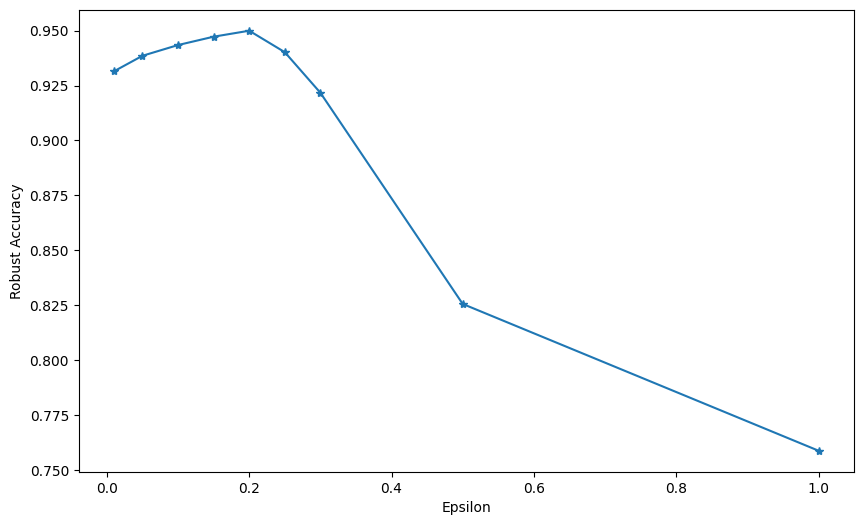

In [81]:
accuracies = []
for pts in attack_points.values():
    scores = model_copy.evaluate(pts, y_test, verbose=0)
    accuracies.append(scores[1])

plt.figure(figsize=(10, 6))
plt.plot(attack_points.keys(), accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Robust Accuracy")
plt.show()

We can see that after the fine tuning the model is pretty robust with a slighty increase until 0.2 before falling down. It's logical since the model has been fine tuned with adversarial exemple that were generated using a value of 0.2 for the epsilon.

### b. LSTM

#### Binary classification

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Let's create a PyTorch dataset

In [42]:
class HITLDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HITLDataset(X_train_scaled, y_train["label_n"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["label_n"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["label_n"].to_numpy())

# Create pytorch dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out
    
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["label_n"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)
model

LSTM(
  (lstm): LSTM(23, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
from tqdm import tqdm

def train(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for X, y in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(1) == y).sum().item()

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, total=len(val_loader)):
            y_pred = model(X)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            val_acc += (y_pred.argmax(1) == y).sum().item()
    return train_loss / len(train_loader), train_acc / len(train_loader.dataset), val_loss / len(val_loader), val_acc / len(val_loader.dataset)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for X, y in test_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            test_acc += (y_pred.argmax(1) == y).sum().item()
            y_pred_list.append(y_pred.argmax(1).cpu().numpy())
            y_true_list.append(y.cpu().numpy())
    return test_loss / len(test_loader), test_acc / len(test_loader.dataset)

100%|██████████| 47/47 [00:00<00:00, 1704.54it/s]


Train loss: 0.4592, Train acc: 0.8465, Val loss: 0.4282, Val acc: 0.8384


100%|██████████| 47/47 [00:00<00:00, 1709.84it/s]


Train loss: 0.3867, Train acc: 0.8469, Val loss: 0.3622, Val acc: 0.8452


100%|██████████| 47/47 [00:00<00:00, 1664.79it/s]


Train loss: 0.3405, Train acc: 0.8625, Val loss: 0.3144, Val acc: 0.8683


100%|██████████| 47/47 [00:00<00:00, 1724.45it/s]


Train loss: 0.2942, Train acc: 0.8774, Val loss: 0.2917, Val acc: 0.8771


100%|██████████| 47/47 [00:00<00:00, 1753.60it/s]


Train loss: 0.2642, Train acc: 0.8881, Val loss: 0.2495, Val acc: 0.8961


100%|██████████| 47/47 [00:00<00:00, 1720.54it/s]


Train loss: 0.2395, Train acc: 0.9014, Val loss: 0.2287, Val acc: 0.9077


100%|██████████| 47/47 [00:00<00:00, 1737.08it/s]


Train loss: 0.2204, Train acc: 0.9095, Val loss: 0.2092, Val acc: 0.9111


100%|██████████| 47/47 [00:00<00:00, 1685.67it/s]


Train loss: 0.2067, Train acc: 0.9156, Val loss: 0.1975, Val acc: 0.9172


100%|██████████| 47/47 [00:00<00:00, 1628.44it/s]


Train loss: 0.1951, Train acc: 0.9187, Val loss: 0.1920, Val acc: 0.9240


100%|██████████| 47/47 [00:00<00:00, 1682.91it/s]


Train loss: 0.1854, Train acc: 0.9253, Val loss: 0.1837, Val acc: 0.9321


100%|██████████| 47/47 [00:00<00:00, 1672.06it/s]


Train loss: 0.1745, Train acc: 0.9301, Val loss: 0.1698, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1755.56it/s]


Train loss: 0.1681, Train acc: 0.9313, Val loss: 0.1657, Val acc: 0.9308


100%|██████████| 47/47 [00:00<00:00, 1731.58it/s]


Train loss: 0.1647, Train acc: 0.9329, Val loss: 0.1600, Val acc: 0.9389


100%|██████████| 47/47 [00:00<00:00, 1662.72it/s]


Train loss: 0.1562, Train acc: 0.9311, Val loss: 0.1638, Val acc: 0.9287


100%|██████████| 47/47 [00:00<00:00, 1667.32it/s]


Train loss: 0.1507, Train acc: 0.9355, Val loss: 0.1497, Val acc: 0.9335


100%|██████████| 47/47 [00:00<00:00, 1696.02it/s]


Train loss: 0.1472, Train acc: 0.9384, Val loss: 0.1431, Val acc: 0.9369


100%|██████████| 47/47 [00:00<00:00, 1716.13it/s]


Train loss: 0.1415, Train acc: 0.9423, Val loss: 0.1713, Val acc: 0.9396


100%|██████████| 47/47 [00:00<00:00, 1675.34it/s]


Train loss: 0.1349, Train acc: 0.9431, Val loss: 0.1377, Val acc: 0.9416


100%|██████████| 47/47 [00:00<00:00, 1682.42it/s]


Train loss: 0.1330, Train acc: 0.9450, Val loss: 0.1382, Val acc: 0.9409


100%|██████████| 47/47 [00:00<00:00, 1563.28it/s]


Train loss: 0.1305, Train acc: 0.9447, Val loss: 0.1520, Val acc: 0.9437


100%|██████████| 47/47 [00:00<00:00, 1650.91it/s]


Train loss: 0.1266, Train acc: 0.9472, Val loss: 0.1275, Val acc: 0.9457


100%|██████████| 47/47 [00:00<00:00, 1649.99it/s]


Train loss: 0.1231, Train acc: 0.9482, Val loss: 0.1295, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1683.87it/s]


Train loss: 0.1205, Train acc: 0.9494, Val loss: 0.1300, Val acc: 0.9498


100%|██████████| 47/47 [00:00<00:00, 1681.87it/s]


Train loss: 0.1177, Train acc: 0.9509, Val loss: 0.1236, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1687.91it/s]


Train loss: 0.1187, Train acc: 0.9531, Val loss: 0.1206, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1690.77it/s]


Train loss: 0.1133, Train acc: 0.9567, Val loss: 0.1189, Val acc: 0.9498


100%|██████████| 47/47 [00:00<00:00, 1702.35it/s]


Train loss: 0.1126, Train acc: 0.9555, Val loss: 0.1208, Val acc: 0.9525


100%|██████████| 47/47 [00:00<00:00, 1713.37it/s]


Train loss: 0.1079, Train acc: 0.9581, Val loss: 0.1175, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1677.75it/s]


Train loss: 0.1061, Train acc: 0.9601, Val loss: 0.1198, Val acc: 0.9484


100%|██████████| 47/47 [00:00<00:00, 1685.55it/s]


Train loss: 0.1049, Train acc: 0.9601, Val loss: 0.1117, Val acc: 0.9511


100%|██████████| 47/47 [00:00<00:00, 1672.60it/s]


Train loss: 0.1027, Train acc: 0.9603, Val loss: 0.1197, Val acc: 0.9532


100%|██████████| 47/47 [00:00<00:00, 1626.34it/s]


Train loss: 0.1007, Train acc: 0.9625, Val loss: 0.1098, Val acc: 0.9572


100%|██████████| 47/47 [00:00<00:00, 1678.21it/s]


Train loss: 0.0987, Train acc: 0.9615, Val loss: 0.1097, Val acc: 0.9511


100%|██████████| 47/47 [00:00<00:00, 1692.60it/s]


Train loss: 0.0982, Train acc: 0.9615, Val loss: 0.1165, Val acc: 0.9579


100%|██████████| 47/47 [00:00<00:00, 1727.87it/s]


Train loss: 0.0951, Train acc: 0.9644, Val loss: 0.1177, Val acc: 0.9504


100%|██████████| 47/47 [00:00<00:00, 1762.69it/s]


Train loss: 0.0959, Train acc: 0.9644, Val loss: 0.1052, Val acc: 0.9586


100%|██████████| 47/47 [00:00<00:00, 1673.25it/s]


Train loss: 0.0956, Train acc: 0.9640, Val loss: 0.1011, Val acc: 0.9620


100%|██████████| 47/47 [00:00<00:00, 1697.43it/s]


Train loss: 0.0924, Train acc: 0.9649, Val loss: 0.1030, Val acc: 0.9640


100%|██████████| 47/47 [00:00<00:00, 1724.09it/s]


Train loss: 0.0943, Train acc: 0.9664, Val loss: 0.1069, Val acc: 0.9572


100%|██████████| 47/47 [00:00<00:00, 1673.36it/s]


Train loss: 0.0909, Train acc: 0.9654, Val loss: 0.1071, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1718.47it/s]


Train loss: 0.0882, Train acc: 0.9666, Val loss: 0.0985, Val acc: 0.9613


100%|██████████| 47/47 [00:00<00:00, 1675.94it/s]


Train loss: 0.0875, Train acc: 0.9666, Val loss: 0.1019, Val acc: 0.9606


100%|██████████| 47/47 [00:00<00:00, 1669.81it/s]


Train loss: 0.0847, Train acc: 0.9691, Val loss: 0.1010, Val acc: 0.9620


100%|██████████| 47/47 [00:00<00:00, 1707.29it/s]


Train loss: 0.0875, Train acc: 0.9672, Val loss: 0.1169, Val acc: 0.9572


100%|██████████| 47/47 [00:00<00:00, 1687.01it/s]


Train loss: 0.0854, Train acc: 0.9660, Val loss: 0.1246, Val acc: 0.9572


100%|██████████| 47/47 [00:00<00:00, 1713.58it/s]


Train loss: 0.0842, Train acc: 0.9686, Val loss: 0.1009, Val acc: 0.9633


100%|██████████| 47/47 [00:00<00:00, 1655.99it/s]


Train loss: 0.0813, Train acc: 0.9701, Val loss: 0.1061, Val acc: 0.9627


100%|██████████| 47/47 [00:00<00:00, 1523.25it/s]


Train loss: 0.0804, Train acc: 0.9698, Val loss: 0.0951, Val acc: 0.9633


100%|██████████| 47/47 [00:00<00:00, 1711.53it/s]


Train loss: 0.0808, Train acc: 0.9694, Val loss: 0.0930, Val acc: 0.9661


100%|██████████| 47/47 [00:00<00:00, 1680.73it/s]


Train loss: 0.0789, Train acc: 0.9700, Val loss: 0.0930, Val acc: 0.9654


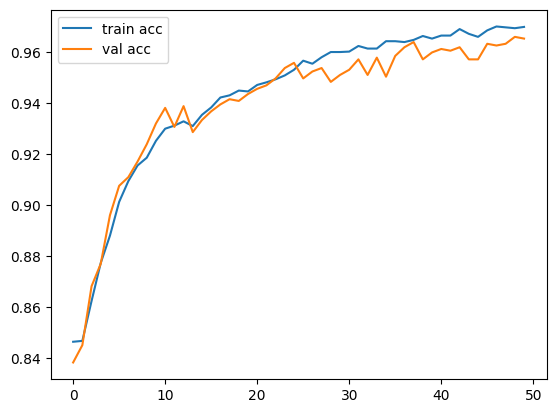

In [46]:
EPOCHS = 50
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# Plot train loss and accuracy
plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [47]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.0866, Test acc: 0.9631


The LSTM model is training in the same way as the DNN model, let's see how the performance compares.

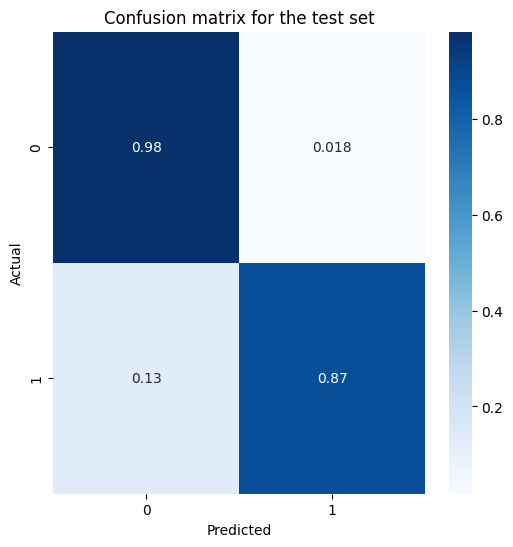

In [48]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

The binary class LSTM has quite a lot of false negatives, just like the DNN, let's see if the multiclass LSTM can do better.

#### Multiclass classification

In [49]:
train_dataset = HITLDataset(X_train_scaled, y_train["new_labels"].to_numpy())
test_dataset = HITLDataset(X_test_scaled, y_test["new_labels"].to_numpy())
val_dataset = HITLDataset(X_val_scaled, y_val["new_labels"].to_numpy())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [50]:
input_dim = X_train_scaled.shape[1]
output_dim = len(y_train["new_labels"].unique())
hidden_dim = 32
model = LSTM(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 47/47 [00:00<00:00, 1685.44it/s]


Train loss: 0.8103, Train acc: 0.8326, Val loss: 0.6008, Val acc: 0.8384


100%|██████████| 47/47 [00:00<00:00, 1719.41it/s]


Train loss: 0.5472, Train acc: 0.8465, Val loss: 0.5328, Val acc: 0.8377


100%|██████████| 47/47 [00:00<00:00, 1467.42it/s]


Train loss: 0.4855, Train acc: 0.8465, Val loss: 0.4654, Val acc: 0.8405


100%|██████████| 47/47 [00:00<00:00, 1676.18it/s]


Train loss: 0.4397, Train acc: 0.8576, Val loss: 0.4572, Val acc: 0.8588


100%|██████████| 47/47 [00:00<00:00, 1761.62it/s]


Train loss: 0.4012, Train acc: 0.8703, Val loss: 0.3896, Val acc: 0.8690


100%|██████████| 47/47 [00:00<00:00, 1725.02it/s]


Train loss: 0.3685, Train acc: 0.8768, Val loss: 0.3665, Val acc: 0.8839


100%|██████████| 47/47 [00:00<00:00, 1773.57it/s]


Train loss: 0.3448, Train acc: 0.8783, Val loss: 0.3351, Val acc: 0.8846


100%|██████████| 47/47 [00:00<00:00, 1751.43it/s]


Train loss: 0.3162, Train acc: 0.8852, Val loss: 0.3194, Val acc: 0.8941


100%|██████████| 47/47 [00:00<00:00, 1713.03it/s]


Train loss: 0.2976, Train acc: 0.8886, Val loss: 0.2962, Val acc: 0.8988


100%|██████████| 47/47 [00:00<00:00, 1747.86it/s]


Train loss: 0.2848, Train acc: 0.8965, Val loss: 0.2794, Val acc: 0.9022


100%|██████████| 47/47 [00:00<00:00, 1749.36it/s]


Train loss: 0.2633, Train acc: 0.9046, Val loss: 0.2676, Val acc: 0.9056


100%|██████████| 47/47 [00:00<00:00, 1738.99it/s]


Train loss: 0.2481, Train acc: 0.9094, Val loss: 0.2490, Val acc: 0.9063


100%|██████████| 47/47 [00:00<00:00, 1724.65it/s]


Train loss: 0.2366, Train acc: 0.9129, Val loss: 0.2323, Val acc: 0.9124


100%|██████████| 47/47 [00:00<00:00, 1664.79it/s]


Train loss: 0.2250, Train acc: 0.9206, Val loss: 0.2208, Val acc: 0.9233


100%|██████████| 47/47 [00:00<00:00, 1692.78it/s]


Train loss: 0.2153, Train acc: 0.9209, Val loss: 0.2115, Val acc: 0.9260


100%|██████████| 47/47 [00:00<00:00, 1781.86it/s]


Train loss: 0.2029, Train acc: 0.9245, Val loss: 0.2020, Val acc: 0.9335


100%|██████████| 47/47 [00:00<00:00, 1687.86it/s]


Train loss: 0.1951, Train acc: 0.9270, Val loss: 0.1964, Val acc: 0.9308


100%|██████████| 47/47 [00:00<00:00, 1759.18it/s]


Train loss: 0.1906, Train acc: 0.9301, Val loss: 0.1885, Val acc: 0.9355


100%|██████████| 47/47 [00:00<00:00, 1767.18it/s]


Train loss: 0.1822, Train acc: 0.9313, Val loss: 0.1940, Val acc: 0.9369


100%|██████████| 47/47 [00:00<00:00, 1715.51it/s]


Train loss: 0.1762, Train acc: 0.9370, Val loss: 0.1881, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1758.05it/s]


Train loss: 0.1734, Train acc: 0.9352, Val loss: 0.1733, Val acc: 0.9464


100%|██████████| 47/47 [00:00<00:00, 1769.97it/s]


Train loss: 0.1653, Train acc: 0.9387, Val loss: 0.1684, Val acc: 0.9375


100%|██████████| 47/47 [00:00<00:00, 1753.16it/s]


Train loss: 0.1607, Train acc: 0.9394, Val loss: 0.1636, Val acc: 0.9409


100%|██████████| 47/47 [00:00<00:00, 1760.24it/s]


Train loss: 0.1564, Train acc: 0.9433, Val loss: 0.1617, Val acc: 0.9443


100%|██████████| 47/47 [00:00<00:00, 1771.20it/s]


Train loss: 0.1515, Train acc: 0.9413, Val loss: 0.1540, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1739.45it/s]


Train loss: 0.1512, Train acc: 0.9455, Val loss: 0.1533, Val acc: 0.9437


100%|██████████| 47/47 [00:00<00:00, 1764.14it/s]


Train loss: 0.1456, Train acc: 0.9465, Val loss: 0.1498, Val acc: 0.9437


100%|██████████| 47/47 [00:00<00:00, 1601.40it/s]


Train loss: 0.1407, Train acc: 0.9457, Val loss: 0.1545, Val acc: 0.9382


100%|██████████| 47/47 [00:00<00:00, 1780.23it/s]


Train loss: 0.1389, Train acc: 0.9509, Val loss: 0.1445, Val acc: 0.9409


100%|██████████| 47/47 [00:00<00:00, 1753.08it/s]


Train loss: 0.1352, Train acc: 0.9503, Val loss: 0.1436, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1778.15it/s]


Train loss: 0.1332, Train acc: 0.9508, Val loss: 0.1394, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 1749.61it/s]


Train loss: 0.1299, Train acc: 0.9515, Val loss: 0.1376, Val acc: 0.9498


100%|██████████| 47/47 [00:00<00:00, 1781.99it/s]


Train loss: 0.1262, Train acc: 0.9523, Val loss: 0.1382, Val acc: 0.9470


100%|██████████| 47/47 [00:00<00:00, 1785.80it/s]


Train loss: 0.1235, Train acc: 0.9576, Val loss: 0.1357, Val acc: 0.9477


100%|██████████| 47/47 [00:00<00:00, 1743.47it/s]


Train loss: 0.1233, Train acc: 0.9550, Val loss: 0.1305, Val acc: 0.9559


100%|██████████| 47/47 [00:00<00:00, 1744.56it/s]


Train loss: 0.1205, Train acc: 0.9576, Val loss: 0.1410, Val acc: 0.9538


100%|██████████| 47/47 [00:00<00:00, 1781.84it/s]


Train loss: 0.1175, Train acc: 0.9577, Val loss: 0.1229, Val acc: 0.9552


100%|██████████| 47/47 [00:00<00:00, 1771.58it/s]


Train loss: 0.1173, Train acc: 0.9584, Val loss: 0.1255, Val acc: 0.9579


100%|██████████| 47/47 [00:00<00:00, 1781.39it/s]


Train loss: 0.1118, Train acc: 0.9598, Val loss: 0.1276, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1775.31it/s]


Train loss: 0.1118, Train acc: 0.9589, Val loss: 0.1225, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 1673.96it/s]


Train loss: 0.1078, Train acc: 0.9613, Val loss: 0.1168, Val acc: 0.9620


100%|██████████| 47/47 [00:00<00:00, 1751.07it/s]


Train loss: 0.1079, Train acc: 0.9632, Val loss: 0.1170, Val acc: 0.9627


100%|██████████| 47/47 [00:00<00:00, 1763.46it/s]


Train loss: 0.1056, Train acc: 0.9652, Val loss: 0.1225, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 1744.16it/s]


Train loss: 0.1044, Train acc: 0.9644, Val loss: 0.1171, Val acc: 0.9579


100%|██████████| 47/47 [00:00<00:00, 1767.59it/s]


Train loss: 0.1019, Train acc: 0.9662, Val loss: 0.1180, Val acc: 0.9599


100%|██████████| 47/47 [00:00<00:00, 1797.18it/s]


Train loss: 0.1012, Train acc: 0.9649, Val loss: 0.1141, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 1412.52it/s]


Train loss: 0.1003, Train acc: 0.9669, Val loss: 0.1154, Val acc: 0.9633


100%|██████████| 47/47 [00:00<00:00, 1708.03it/s]


Train loss: 0.0967, Train acc: 0.9667, Val loss: 0.1103, Val acc: 0.9606


100%|██████████| 47/47 [00:00<00:00, 1773.38it/s]


Train loss: 0.0969, Train acc: 0.9647, Val loss: 0.1111, Val acc: 0.9593


100%|██████████| 47/47 [00:00<00:00, 1710.21it/s]


Train loss: 0.0961, Train acc: 0.9677, Val loss: 0.1123, Val acc: 0.9613


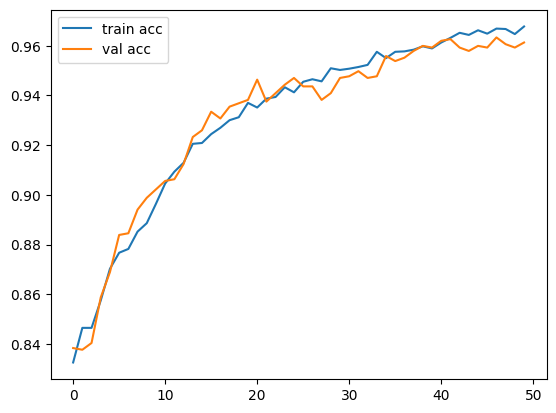

In [51]:
EPOCHS = 50
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for _ in range(EPOCHS):
    train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

plt.plot(train_acc_list, label="train acc")
plt.plot(val_acc_list, label="val acc")
plt.legend()
plt.show()

In [52]:
test_loss, test_acc = test(model, test_loader, criterion)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.1039, Test acc: 0.9609


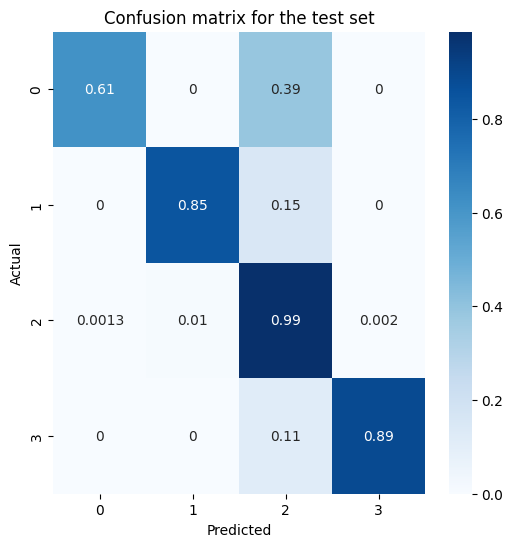

In [53]:
# Predict on test set
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for X, y in test_loader:
        y_pred = model(X)
        y_pred_list.append(y_pred.argmax(1).cpu().numpy())
        y_true_list.append(y.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, title="Confusion matrix for the test set")

This is better overall, however we can see that the model is struggly with the 1st class, as it's confusing it with other classes. It's because the class is more present in the dataset. The LSTM architecture is not suited for this kind of problem as its sensitive to the class imbalance.

The DNN performs better than the LSTM and give very satisfying results.

## 3. Supervised classifiers

### a. Decision Tree

#### Multiclass classification

We will not use the Decision Tree for the binary classification, as we want to focus on the features importance.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7364, 23), (1842, 23), (7364, 2), (1842, 2))

Define the model with empirical parameters

In [56]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [57]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [58]:
preds = pipeline.predict(X_test)

In [59]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9462540716612378
Recall:  0.6880059330578738
F1:  0.7314654460625277
MCC:  0.8115226264628511
Balanced accuracy:  0.6880059330578738


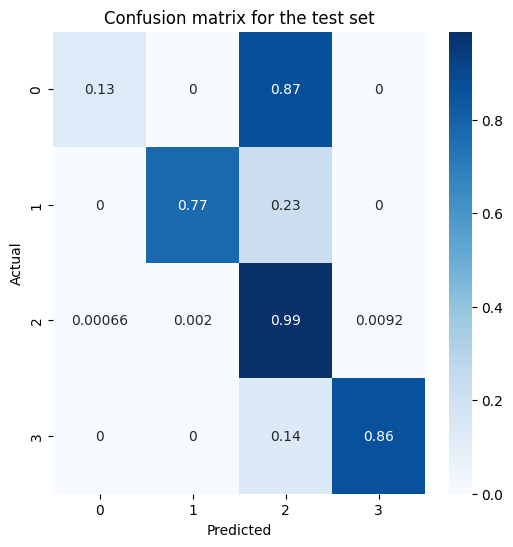

In [60]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

The decision tree is very sensitive to data imbalance, explaining the bad results.

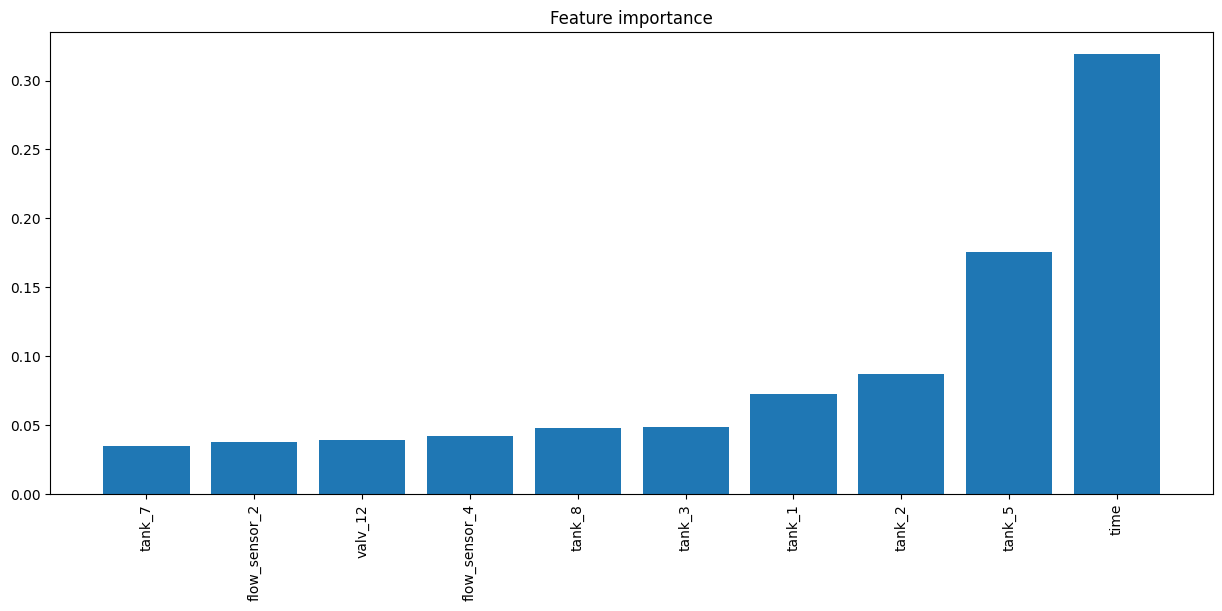

In [61]:
def plot_feature_importance(clf):
    importance = clf.feature_importances_
    idx = np.argsort(importance)[-10:]
    importance = importance[idx]

    plt.figure(figsize=(15, 6))
    plt.title("Feature importance")
    plt.bar([x for x in range(len(importance))], importance)
    plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
    plt.show()

plot_feature_importance(clf)

The model is focusing too much on the time column, which is not relevant for the classification. Let's remove it and see if the model performs better. We will also try to handle class imbalance by using the `class_weight` parameter.

#### Without contextual information

In [62]:
df_physical_no_context = remove_physical_contextual_columns(df_physical)
df_physical_no_context

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,pump_2,...,valv_16,valv_17,valv_18,valv_19,valv_20,valv_21,valv_22,label_n,label,attack
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,normal,1
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201,4,1037,7,452,300,432,80,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9202,3,1059,7,439,296,431,88,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9203,4,1091,8,429,291,431,96,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0
9204,4,1131,8,417,288,421,96,0,1,0,...,0,0,0,0,1,0,0,0.0,normal,0


In [63]:
df_physical_prepared, df_physical_labels = prepare_HTIL_physical_dataset(df_physical_no_context)
df_physical_prepared.head()

,tank_1,tank_2,tank_3,tank_4,tank_5,tank_6,tank_7,tank_8,pump_1,pump_2,...,pump_6,flow_sensor_1,flow_sensor_2,flow_sensor_4,valv_12,valv_15,valv_17,valv_18,valv_20,valv_22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(df_physical_prepared, df_physical_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7364, 22), (1842, 22), (7364, 2), (1842, 2))

In [65]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state
}

clf = DecisionTreeClassifier(**params)

In [66]:
pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [67]:
preds = pipeline.predict(X_test)

In [68]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.9093376764386536
Recall:  0.5985431681275639
F1:  0.6701941184992033
MCC:  0.6636310742802625
Balanced accuracy:  0.5985431681275639


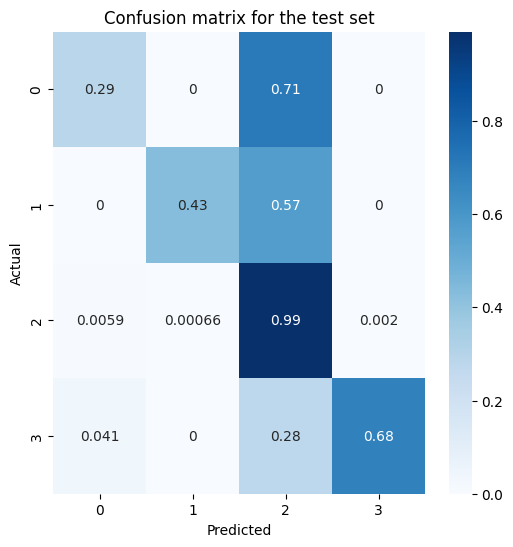

In [69]:
plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

It is still not great, but it's better than before. We will try to fix this by using the `class_weight` parameter.

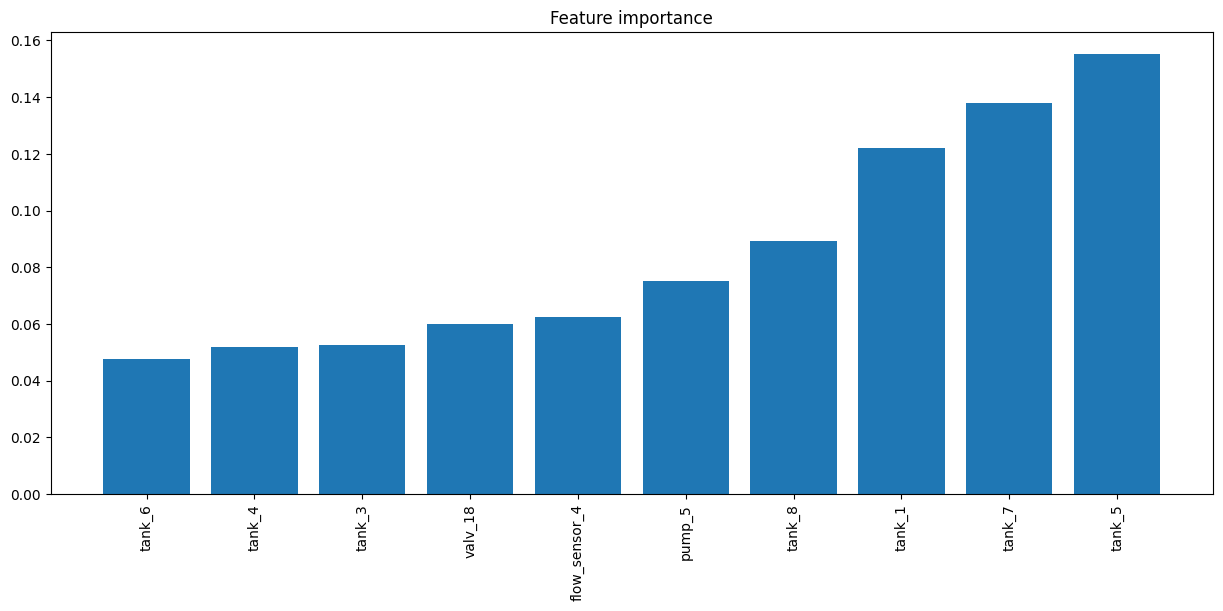

In [70]:
plot_feature_importance(clf)

Accuracy:  0.8604777415852335
Recall:  0.9032609495946987
F1:  0.8198354103357238
MCC:  0.663623364956895
Balanced accuracy:  0.9032609495946987


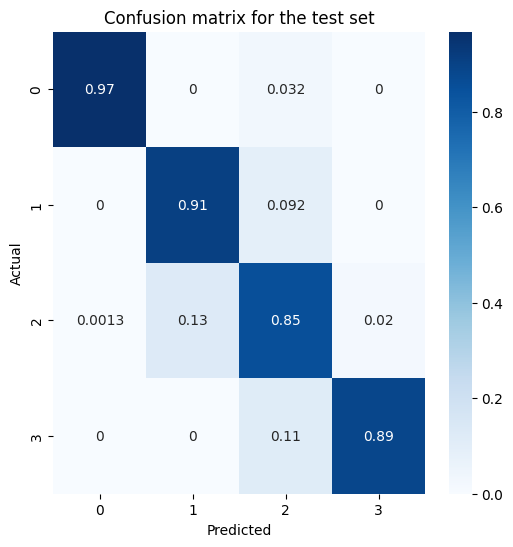

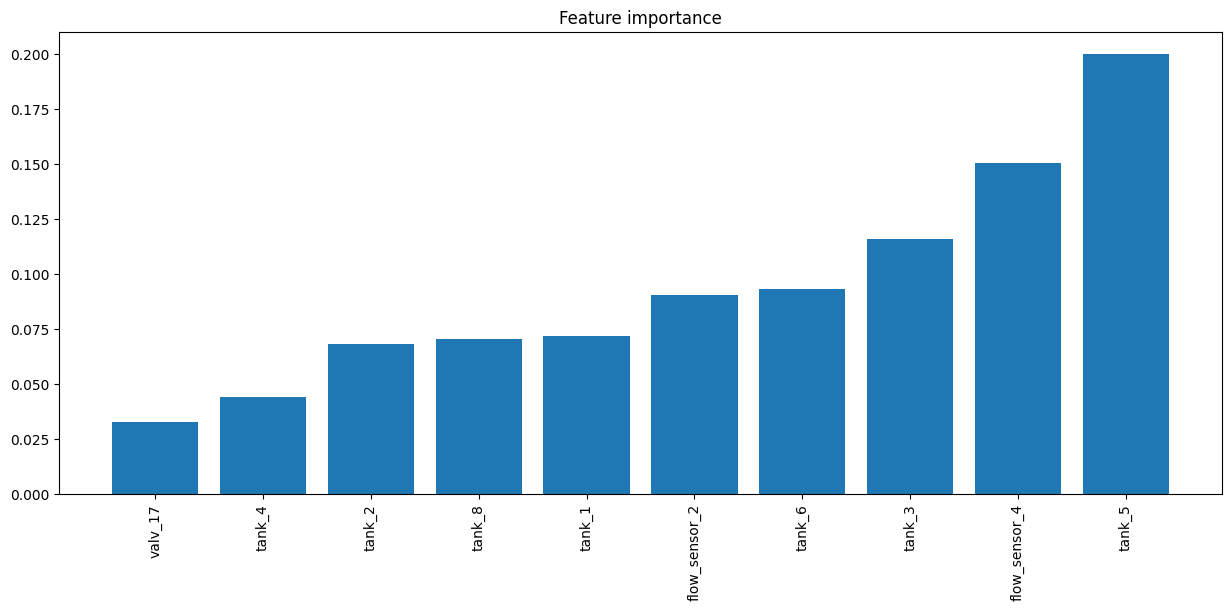

In [71]:
params = {
    'max_depth': 8,
    'criterion': 'gini',
    'splitter': 'best',
    'random_state': random_state,
    'class_weight': 'balanced'
}

clf = DecisionTreeClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

X_train = X_train[y_train["new_labels"] != 4]
y_train = y_train[y_train["new_labels"] != 4]
X_test = X_test[y_test["new_labels"] != 4]
y_test = y_test[y_test["new_labels"] != 4]

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

plot_feature_importance(clf)

After applying the balanced class weight, the results are better. The model is able to detect 90% of the anomalies, but it has a lot of confusion between 2->1 and 3->2. The feature importance is pretty even, with a bigger focus on `tank_5`, but it doesn't seem to be a problem.

### b. Random Forest

Let's apply the balanced class weights everytime from now on.

Accuracy:  0.9185667752442996
Recall:  0.9536846492354968
F1:  0.8870884573107226
MCC:  0.787780941145144
Balanced accuracy:  0.9536846492354968


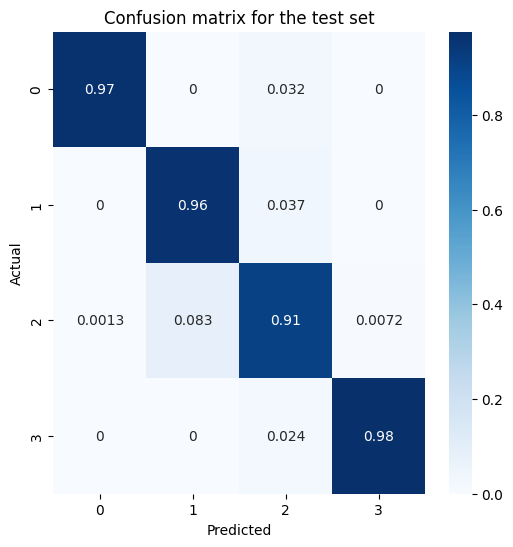

In [72]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth': 8,
    'criterion': 'gini',
    'n_estimators': 100,
    'random_state': 42,
    'class_weight': 'balanced'
}

clf = RandomForestClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

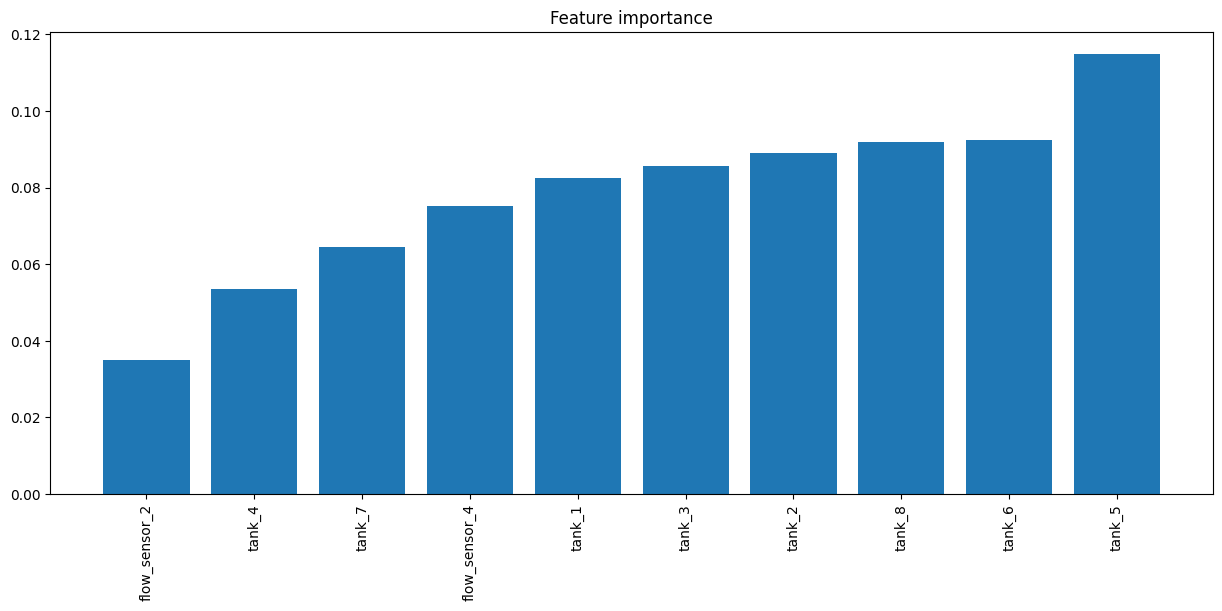

In [73]:
plot_feature_importance(clf)

Here, using class weights and after removing the time information, we observe even better results than with the Decision Tree. The feature `tank_5` is still the most important, but the model is able to detect 95% of the anomalies.

### c. XGBoost

Accuracy:  0.990770901194354
Recall:  0.9703809482210151
F1:  0.9800655751102632
MCC:  0.9691964167380849
Balanced accuracy:  0.9703809482210151


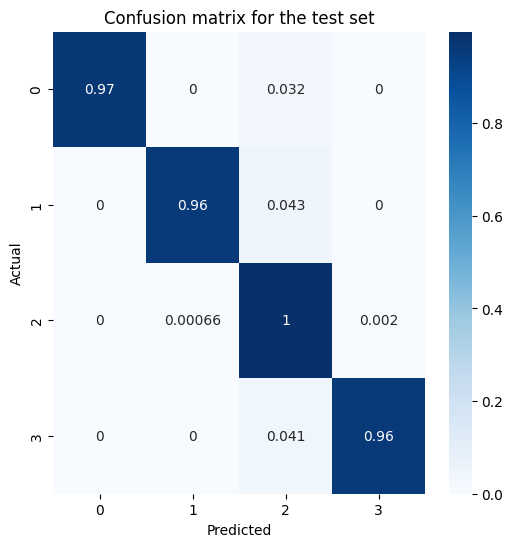

In [74]:
from xgboost import XGBClassifier

params = {
    'max_depth': 8,
    'n_estimators': 100,
    'random_state': 42
}

clf = XGBClassifier(**params)

pipeline = make_pipeline(
    StandardScaler(),
    clf
)

pipeline.fit(X_train, y_train["new_labels"])

preds = pipeline.predict(X_test)

print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

plot_confusion_matrix(y_test["new_labels"], preds.round(), title="Confusion matrix for the test set")

The XGBoost model is the best so far, with almost 97% Recall and 99% Accuracy.

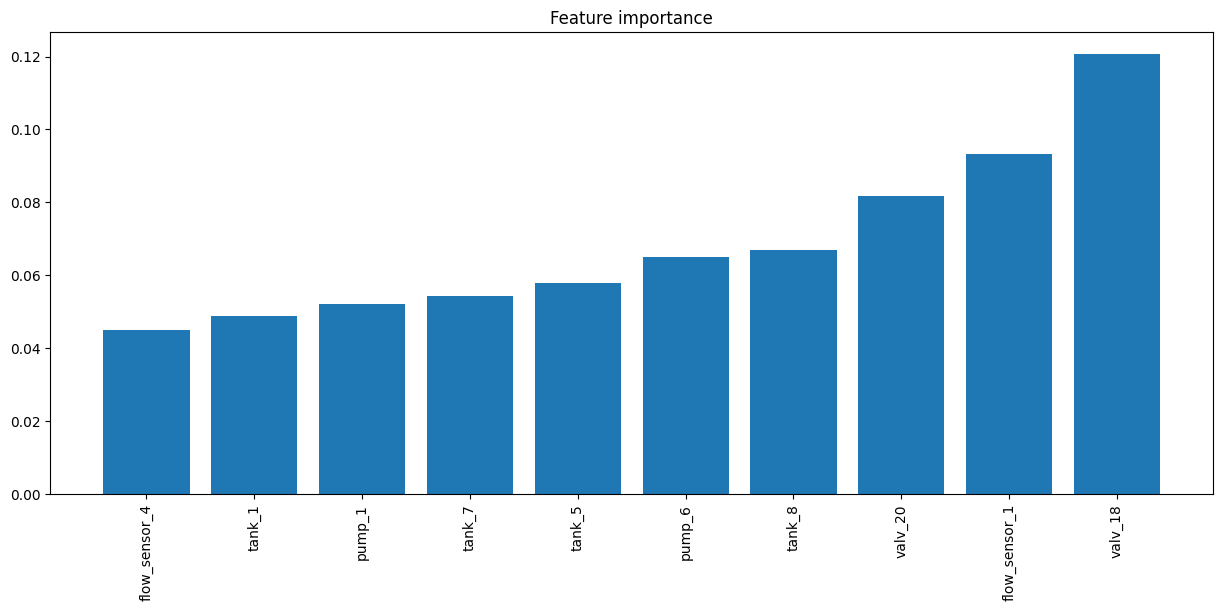

In [75]:
plot_feature_importance(clf)

In [94]:
import plotly.express as px

df_plot = df_physical_prepared.copy()
df_plot["new_labels"] = df_physical_labels["new_labels"]

fig = px.scatter_3d(df_plot, x='valv_18', y='flow_sensor_1', z='valv_20', color='new_labels')
fig.show()

This 3D visualization is very interesting, as we see clear clusters and we can understand why XGBoost is the best classifier so far. The 3 most important features draw a clear separation between the normal and the attack data. Also, these 3 features are not used by the other models, which explains why XGBoost is better.

## 4. Conclusion

In conclusion, the XGBoost model is the best one for this dataset. It has the best recall and accuracy. The DNN model is also a good choice, as it has a good recall and precision, but it's not as good as the XGBoost.

The multiclass classification is better than the binary classification, as it has a better recall and accuracy. The binary classification is not suited for this dataset, as it gives us a lot of false negatives in most models.

Removing contextual information such as the time is a good idea, as it improves the results of the models. However, it's not enough to get good results, we also need to balance the classes. Once done, the results are much better.